In [1]:
import tensorflow as tf # ML library for graphs
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import pandas as panda
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

/Users/dmevada/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
TRAIN_DIR = '<place holder>'
TEST_DIR = '<place holder>'
IMG_SIZE = 80# our images are 80x80x3

In [3]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == 'chair': return [1,0,0,0]
    elif word_label == 'kitchen': return [0,1,0,0]
    elif word_label == 'knife': return [0,0,1,0]
    elif word_label == 'saucepan': return [0,0,0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = TRAIN_DIR + '/' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data_mc.npy', training_data)
    return training_data

In [5]:
#If you are reading images, make the line below uncomment
#train_data = create_train_data()
#If you are reading .npy file, use the line below.
train_data = np.load('train_data_mc.npy')
#print(train_data)

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = TEST_DIR + '/' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),label])       
    shuffle(testing_data)
    np.save('test_data_mc.npy', testing_data)
    return testing_data

In [7]:
#If you are reading images, make the line below uncomment.

#test_data = process_test_data()

#If you are reading .npy file, use the line below.
test_data = np.load('test_data_mc.npy')

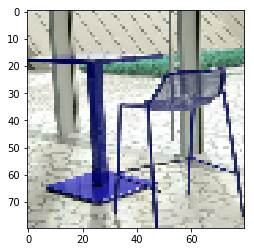

In [8]:
plt.imshow(np.array(train_data[180][0]))

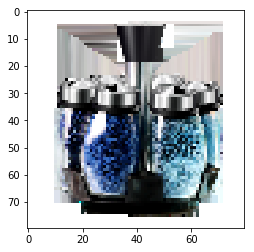

In [9]:
#A KITCHEN
plt.imshow(np.array(train_data[100][0]))

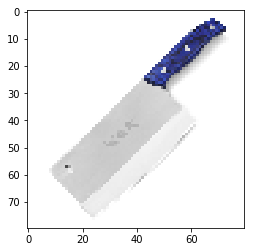

In [10]:
# A KNIFE
plt.imshow(np.array(train_data[111][0]))

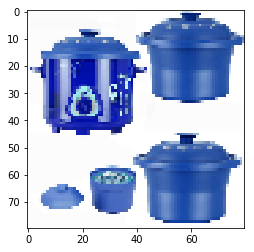

In [11]:
# A SAUCEPAN
plt.imshow(np.array(train_data[154][0]))

In [12]:
#Splitting into Training and CV datasets
train = train_data[:4800]
cv = train_data[4800:]
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
cv_y = np.array([i[1] for i in cv])
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = np.array([i[1] for i in test_data])
print(X.shape)
print(Y[2],type(Y[2]))
print(cv_x.shape)
print(test_x.shape)


(4800, 80, 80, 3)
[0 0 0 1] <class 'numpy.ndarray'>
(400, 80, 80, 3)
(1267, 80, 80, 3)


In [13]:
#HYPERPARAMETERS
steps = 4800 # number of samples in trainiing set
epochs = 50 #number of epochs
step_size = 32 # 
total_batch = int(steps/step_size)
LR = 0.0001

In [14]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

print(X[5].shape)

(80, 80, 3)


In [15]:
#Resetting the graph
tf.reset_default_graph()
#Defining placeholders
x = tf.placeholder(tf.float32,shape=[None,80,80,3])
y_true = tf.placeholder(tf.float32,shape=[None,4])

In [16]:
#Defining the graph
with tf.name_scope('Model'):
    convo_1 = convolutional_layer(x,shape=[4,4,3,32])
    convo_1_pooling = max_pool_2by2(convo_1)
    convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,16])
    convo_2_pooling = max_pool_2by2(convo_2)
    convo_3 = convolutional_layer(convo_2_pooling,shape=[4,4,16,8])
    convo_3_pooling = max_pool_2by2(convo_3)
    convo_4 = convolutional_layer(convo_3_pooling,shape=[4,4,8,4])
    convo_4_pooling = max_pool_2by2(convo_4)
    convo_2_flat = tf.reshape(convo_4_pooling,[-1,5*5*4])
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,80))
    hold_prob1 = tf.placeholder(tf.float32)
    full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob1)
    
    full_layer_two = tf.nn.relu(normal_full_layer(full_one_dropout,40))
    hold_prob2 = tf.placeholder(tf.float32)
    full_two_dropout = tf.nn.dropout(full_layer_two,keep_prob=hold_prob2)
                                     
    full_layer_three = tf.nn.relu(normal_full_layer(full_two_dropout,20))
    hold_prob3 = tf.placeholder(tf.float32)
    full_three_dropout = tf.nn.dropout(full_layer_three,keep_prob=hold_prob3)
    
    full_layer_four = tf.nn.relu(normal_full_layer(full_three_dropout,10))
    hold_prob4 = tf.placeholder(tf.float32)
    full_four_dropout = tf.nn.dropout(full_layer_four,keep_prob=hold_prob4)
    
    y_pred = normal_full_layer(full_four_dropout,4)

In [17]:
#Defining Loss Function
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [18]:
#Defining objectve
with tf.name_scope('ADAM'):
    train = tf.train.AdamOptimizer(learning_rate=LR).minimize(cross_entropy)

In [19]:
#Defining Accuracy
with tf.name_scope('Accuracy'):
    matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [20]:
#Starting variables
init = tf.global_variables_initializer()
tf.summary.scalar("loss", cross_entropy)
tf.summary.scalar("accuracy", acc)
merged_summary_op = tf.summary.merge_all()

In [21]:
#Defining empty lists to keep results
acc_list = []
cross_entropy_list = []
acc_train = []
saver = tf.train.Saver()

In [23]:
#Training and saving the result
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(TRAIN_DIR, graph=tf.get_default_graph())
    for i in range(epochs):
        for j in range(0,steps,step_size):            
            _ , c , summary,d = sess.run([train,cross_entropy,merged_summary_op,acc],feed_dict={x:X[j:j+step_size] , y_true:Y[j:j+step_size] ,hold_prob1:0.5,hold_prob2:0.5,hold_prob3:0.5,hold_prob4:0.5})
            summary_writer.add_summary(summary, i * total_batch + j)
            acc_train.append(d)
            mean_of_cross_entropy = sess.run(cross_entropy,feed_dict={x:cv_x,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})
            mean_of_acc = sess.run(acc,feed_dict={x:cv_x ,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})
            cross_entropy_list.append(mean_of_cross_entropy)
            acc_list.append(mean_of_acc)
        print(i,mean_of_cross_entropy,mean_of_acc)
    saver.save(sess, os.getcwd()+"\\CNN_MC.ckpt")
    print("test accuracy = ",np.mean([sess.run(acc,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(acc,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(acc,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})]))   
    print("cross_entropy loss = ",np.mean([sess.run(cross_entropy,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})]))

KeyboardInterrupt: 

In [ ]:
#Plotting the Accuracy
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Plotting the Cross Entropy Loss on CV data
pd.Series(cross_entropy_list).plot(kind='line',title='Cross Entropy Loss on CV data')
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [ ]:
with tf.Session() as session:
    saver.restore(session, "CNN_MC.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([y_pred], feed_dict={x:test_x[0:1] , hold_prob1:1,hold_prob2:1,hold_prob3:1,hold_prob4:1})
    print(k)

In [ ]:
chair,kitchen,knife,saucepan = k[0][0][0],k[0][0][1],k[0][0][2],k[0][0][3]
print(chair,kitchen,knife,saucepan)

In [ ]:
chair_exp = np.exp(chair)
kitchen_exp = np.exp(kitchen)
knife_exp = np.exp(knife)
saucepan_exp = np.exp(saucepan)

In [ ]:
chair_prob = chair_exp / (chair_exp + kitchen_exp + knife_exp + saucepan_exp)
kitchen_prob = kitchen_exp /(chair_exp + kitchen_exp + knife_exp + saucepan_exp)
knife_prob = knife_exp /(chair_exp + kitchen_exp + knife_exp + saucepan_exp)
saucepan_prob = saucepan_exp / (chair_exp + kitchen_exp + knife_exp + saucepan_exp)
print("Chair_prob %s, Kitchen_prob %s Knife prob %s Saucepan_prob %s" %(round(chair_prob,3) ,round(kitchen_prob,3) ,round(knife_prob,3),round(saucepan_prob,3)))

In [ ]:
# A SAUCEPAN
plt.imshow(np.array(test_x[0]))
plt.title("Chair_prob %s, Kitchen_prob %s Knife prob %s Saucepan_prob %s" %(round(chair_prob,3) ,round(kitchen_prob,3) ,round(knife_prob,3),round(saucepan_prob,3)))

In [ ]:
with tf.Session() as session:
    saver.restore(session, "CNN_MC.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([y_pred], feed_dict={x:test_x[0:64] , hold_prob1:1,hold_prob2:1,hold_prob3:1,hold_prob4:1})

In [ ]:
np.array(k).shape
#Reshaping k
k = np.array(k).reshape(64,4)

In [ ]:
pred_labels = []
for i in range(64):
    r = np.round(np.array(np.exp(k[i])/sum(np.exp(k[i]))),3).argmax()
    if r ==0 : pred_labels.append("chair")
    elif r ==1: pred_labels.append("kitchen")
    elif r ==2: pred_labels.append("knife")
    elif r ==3: pred_labels.append("saucepan")

In [ ]:
#Multiple images parameters
w=80
h=80
columns = 8
rows = 8
images = test_x[:64]
images.shape

In [ ]:
fig = plt.figure(figsize=(20, 20))
for m in range(1, columns*rows +1):
    img = images[m-1].reshape([80, 80, 3])
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Pred: " + pred_labels[m-1])
    plt.axis('off')
plt.show()
